# Analysis of numerical experiments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
settings = {"normal":"S5I3C25m10b70r2d25K10T10",
             "m5":"S5I3C25m5b70r2d25K10T10",
             "m15":"S5I3C25m15b70r2d25K10T10",  
             "m20":"S5I3C25m20b70r2d25K10T10",
             "b50":"S5I3C25m10b50r2d25K10T10",
             "b90":"S5I3C25m10b90r2d25K10T10",
             "r1":"S5I3C25m10b70r1d25K10T10", 
             "r3":"S5I3C25m10b70r3d25K10T10",
             "d10":"S5I3C25m10b70r2d10K10T10", 
             "d40":"S5I3C25m10b70r2d40K10T10"}
dist = "poisson"
folder_prefix = "BS/"
result_folder = "BS/Analysis/{}/".format(dist)
file_suffix = "_Near0N1000.csv"
models = ["MD", "MS"]
periods = range(10, 0, -1)
alpha_range = range(20, -1, -2)
policy_names = {"MD_naive":"ND", "MS_naive":"NS"}
policy_names.update({"M{}_bs_b{}".format(m, alpha):"A{}_alpha{}".format(m, alpha) 
                    for m in ["D","S"] for alpha in alpha_range})
policies = list(policy_names.keys())

In [2]:
def concat(dfs, policies, first="MD_naive"):
    # Rename
    periods = list(range(10, 0, -1))
    general = ["Experiment"] + ["order_t" + str(i) for i in periods]
    items = {"decision_t":"DC", "rev_acc_t":"RAC", "rev_rej_t":"RRJ", "rev_order_t":"RO", "rev_ind_t":"RI", "acceptable_t":"AC"}
    revs = {"revenue":"R", "first_k_avg_rev":"AVG", "sold_out":"S", "time":"T"}
    concat_list = [dfs[first][general]]
    for s in policies:
        rename_dic = {r:"{}_{}".format(revs[r], policy_names[s]) for r in revs}
        rename_dic.update({"{}{}".format(i, t):"{}{}_{}".format(items[i], t, policy_names[s])
                            for i in items for t in periods})
        dfs[s] = dfs[s].rename(columns=rename_dic)
        concat_list.append(dfs[s][list(rename_dic.values())])

    # Concat
    df = pd.concat(concat_list, axis=1)
    return df

def get_item_by_keyword(df, keywords, except_key = "NONE"):
    df_key = df
    for key in keywords:
        keys = [k for k in df_key.columns if key in k and except_key not in k]
        df_key = df_key[keys]
    return df_key

def add_gap(df, benchmark):
    for policy in df.columns:
        if policy == benchmark: continue
        df["{}_gap".format(policy)] = (df[policy] - df[benchmark]).divide(df[benchmark])
    return df

def add_percentage(df):
    for key in df.columns:
        df["{}(%)".format(key)] = pd.Series(["{0:.2f}%".format(val * 100) 
                                             for val in df[key]], 
                                            index=df.index)
    return df

## Read files and concat

In [3]:
# Read files
dfs = {}
for s in settings:
    setting_name = settings[s]
    folder_suffix = "_{}".format(dist) if dist != "geometric" else ""
    folder = folder_prefix + setting_name + folder_suffix + "/"
    dfs[s] = {}
    for mode in policies:
        path = folder + mode + file_suffix
        dfs[s][mode] = pd.read_csv(path)

In [4]:
# Concat each policies
dfs_concat = {}
for s in settings:
    dfs_concat[s] = concat(dfs[s], policies)

## Find optimal $\alpha$ for adjusted policies in each setting

In [5]:
# Find best alpha for AD and AS in each setting
target = "R_"
adj_policies = ["AD", "AS"]
items = ["alpha", "avg_rev"]
opt_alphas = {"{}_{}".format(p, i):[] for p in adj_policies for i in items}
opt_policies = {}

for s in settings:
    opt_policies[s] = ["ND", "NS"]
    for p in adj_policies:
        avg_revs = get_item_by_keyword(dfs_concat[s], [target, p]).mean()
        opt_alphas["{}_alpha".format(p)].append(avg_revs.idxmax())
        opt_alphas["{}_avg_rev".format(p)].append(avg_revs.max())
        opt_policies[s].append(avg_revs.idxmax()[2:])

df_alphas = pd.DataFrame(opt_alphas, index=settings)
df_alphas.index.name = "Setting"
path = result_folder + "opt_alphas.csv"
df_alphas.to_csv(path)

print(opt_policies)
df_alphas

{'normal': ['ND', 'NS', 'AD_alpha20', 'AS_alpha20'], 'm5': ['ND', 'NS', 'AD_alpha20', 'AS_alpha20'], 'm15': ['ND', 'NS', 'AD_alpha20', 'AS_alpha16'], 'm20': ['ND', 'NS', 'AD_alpha20', 'AS_alpha6'], 'b50': ['ND', 'NS', 'AD_alpha16', 'AS_alpha16'], 'b90': ['ND', 'NS', 'AD_alpha20', 'AS_alpha4'], 'r1': ['ND', 'NS', 'AD_alpha20', 'AS_alpha20'], 'r3': ['ND', 'NS', 'AD_alpha8', 'AS_alpha4'], 'd10': ['ND', 'NS', 'AD_alpha20', 'AS_alpha20'], 'd40': ['ND', 'NS', 'AD_alpha0', 'AS_alpha0']}


,AD_alpha,AD_avg_rev,AS_alpha,AS_avg_rev
Setting,,,,
normal,R_AD_alpha20,507733.975,R_AS_alpha20,508978.270
m5,R_AD_alpha20,688479.420,R_AS_alpha20,688479.420
m15,R_AD_alpha20,370502.473,R_AS_alpha16,375038.998
m20,R_AD_alpha20,310612.369,R_AS_alpha6,311922.232
b50,R_AD_alpha16,461361.954,R_AS_alpha16,464953.270
b90,R_AD_alpha20,573465.105,R_AS_alpha4,575096.120
r1,R_AD_alpha20,516475.686,R_AS_alpha20,519040.469
r3,R_AD_alpha8,535062.118,R_AS_alpha4,538176.664
d10,R_AD_alpha20,496398.930,R_AS_alpha20,497372.874


___
## Gaps

In [6]:
# Find gaps
target = "R_"
gaps = {}
for setting in settings:
    keys = ["{}{}".format(target, p) for p in ["ND", "NS"]]
    keys += [df_alphas.loc[setting]["{}_alpha".format(p)] for p in adj_policies]
    revs = get_item_by_keyword(dfs_concat[setting], [target])[keys]
    revs = revs.rename(columns={k:k.split("_")[1] for k in revs.columns})
    gaps[setting] = add_gap(revs.copy(), benchmark="ND")

In [7]:
# Find gap avg and std in each setting
smarter_policies = ["NS", "AD", "AS"]
gaps_des = {"{}_gap_{}".format(p, i):[] for p in smarter_policies for i in ["avg", "std"]}
for s in settings:
    only_gap = get_item_by_keyword(gaps[s], ["gap"])
    gap_avg = only_gap.mean().to_dict()
    gap_std = only_gap.std().to_dict()
    for k in only_gap.columns:
        gaps_des["{}_avg".format(k)].append(gap_avg[k])
        gaps_des["{}_std".format(k)].append(gap_std[k])

# add total gap
total_gap = pd.concat(list(gaps.values()), axis = 0)
total_only_gap = get_item_by_keyword(total_gap, ["gap"])
total_avg_gap = total_only_gap.mean().to_dict()
total_std_gap = total_only_gap.std().to_dict()
for p in smarter_policies:
    gaps_des["{}_gap_avg".format(p)].append(total_avg_gap["{}_gap".format(p)])
    gaps_des["{}_gap_std".format(p)].append(total_std_gap["{}_gap".format(p)])
    
    
indexes = list(settings.keys()) + ["total"] 
df_gaps = pd.DataFrame(gaps_des, index = indexes)
df_gaps

,NS_gap_avg,NS_gap_std,AD_gap_avg,AD_gap_std,AS_gap_avg,AS_gap_std
normal,0.002925,0.013273,0.001091,0.019601,0.003541,0.019364
m5,-0.000003,0.000103,0.000015,0.000475,0.000015,0.000475
m15,0.014701,0.073494,0.000000,0.000000,0.015718,0.074038
m20,0.002853,0.039612,0.000000,0.000000,0.004371,0.041691
b50,0.006977,0.016831,0.001798,0.017712,0.009750,0.023218
b90,0.002819,0.020114,0.000215,0.007492,0.003234,0.020608
r1,0.005372,0.016334,0.001840,0.016995,0.006843,0.019746
r3,0.006582,0.018227,0.000146,0.003725,0.006146,0.017612
d10,0.002206,0.016534,0.001972,0.011455,0.004039,0.017567
d40,-0.000282,0.019804,0.000000,0.000000,0.000141,0.019583


In [8]:
# Find gap percentages
df_gaps_perc = add_percentage(df_gaps.copy())
path = result_folder + "gaps.csv"
df_gaps_perc.index.name = "Setting"
df_gaps_perc.to_csv(path)
get_item_by_keyword(df_gaps_perc, ["%"])

,NS_gap_avg(%),NS_gap_std(%),AD_gap_avg(%),AD_gap_std(%),AS_gap_avg(%),AS_gap_std(%)
Setting,,,,,,
normal,0.29%,1.33%,0.11%,1.96%,0.35%,1.94%
m5,-0.00%,0.01%,0.00%,0.05%,0.00%,0.05%
m15,1.47%,7.35%,0.00%,0.00%,1.57%,7.40%
m20,0.29%,3.96%,0.00%,0.00%,0.44%,4.17%
b50,0.70%,1.68%,0.18%,1.77%,0.97%,2.32%
b90,0.28%,2.01%,0.02%,0.75%,0.32%,2.06%
r1,0.54%,1.63%,0.18%,1.70%,0.68%,1.97%
r3,0.66%,1.82%,0.01%,0.37%,0.61%,1.76%
d10,0.22%,1.65%,0.20%,1.15%,0.40%,1.76%


___
## Times

In [9]:
# Find average excution time (s)
target = "T"
times_concat = {p:[] for p in ["ND", "NS", "AD", "AS"]}
for setting in settings:
    keys = ["{}_{}".format(target, p) for p in opt_policies[setting]]
    times = get_item_by_keyword(dfs_concat[setting], [target])[keys]
    times = times.rename(columns={k:k.split("_")[1] for k in times.columns})
    avg_time = times.mean().to_dict()
    for p in avg_time:
        times_concat[p].append(avg_time[p])

df_exe_times = pd.DataFrame(times_concat, index=settings)
df_exe_times.mean()

ND    0.0015
NS    0.3951
AD    0.0013
AS    0.4033
dtype: float64

In [10]:
# Find tuning time of AD, AS

target = "T"
tuning_times = {p:[] for p in adj_policies}
for setting in settings:
    for p in adj_policies:
        total_tuning_time = get_item_by_keyword(dfs_concat[setting], [target, p]).sum().sum()
        tuning_times[p].append(total_tuning_time)

df_tuning_times = pd.DataFrame(tuning_times, index=settings)
df_tuning_times.mean()

AD      15.3
AS    4386.1
dtype: float64

___
## Decisions

In [11]:
# Show the decisions of 4 policies
titles = {"m5":r"high individual demand (low $m$)", "normal":"normal",
          "m15":r"moderate individual demand (moderate $m$)", "m20":r"low individual demand (high $m$)",
          "b50":r"low order price (low $\beta$)", "b90":r"high order price (high $\beta$)",
          "r1":r"low no-order rate (low $\theta$)", "r3":r"high no-order rate (high $\theta$)",
          "d10":r"low demand in an order (low $\gamma$)", "d40":r"high demand in an order (high $\gamma$)"}
def print_decision(dfs_concat, settings, path = ""):
    inch = 6
    fig, axs = plt.subplots(len(settings), 2)
    fig.set_size_inches(inch*2, 5*len(settings))
    target = "DC"
    
    for ps in range(len(settings)):
        for p in range(len(settings[ps])):
            setting = settings[ps][p]   
            
            # Build a df for acceptance rate
            acc_rates = {pol.split("_")[0]:[] for pol in opt_policies[setting]}
            for policy in opt_policies[setting]:
                acc_rate = get_item_by_keyword(dfs_concat[setting], [target, policy]).mean().to_dict()
                for t in periods:
                    key = "{}{}_{}".format(target, t, policy)
#                     print(key)
                    acc_rates[policy.split("_")[0]].append(acc_rate[key])
            
            # Set figure
            fig_index = (ps, p)
            if len(settings) == 1:
                fig_index = p    
            axs[fig_index].set_title("{}".format(titles[setting]), fontsize='16')
            axs[fig_index].set_xlabel("Period", fontsize='14')
            axs[fig_index].set_ylabel("Acceptance rate", fontsize='14')
            axs[fig_index].tick_params(axis='both', which='major', labelsize=12)
            axs[fig_index].set_ylim(-0.05, 1)
            df_acc_rates = pd.DataFrame(acc_rates, index = periods)
            df_acc_rates.plot(ax=axs[fig_index], style=['-', '--*', '-.o', ':x'])
    fig.tight_layout()
    if path != "":
        plt.savefig(path)

/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs10030746/

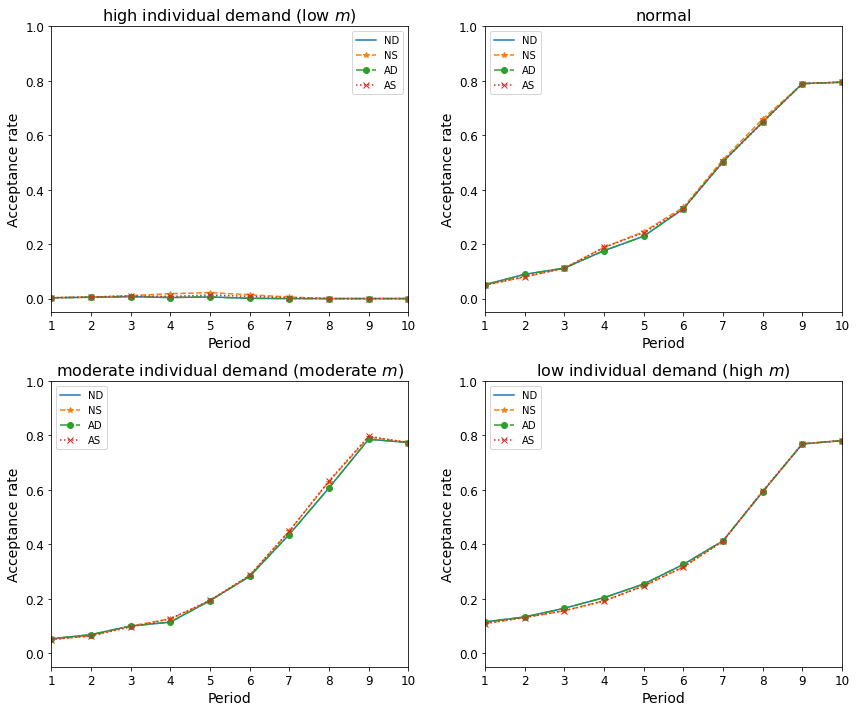

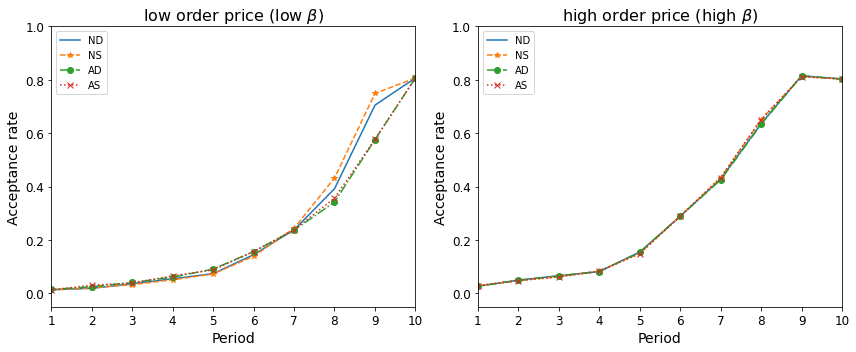

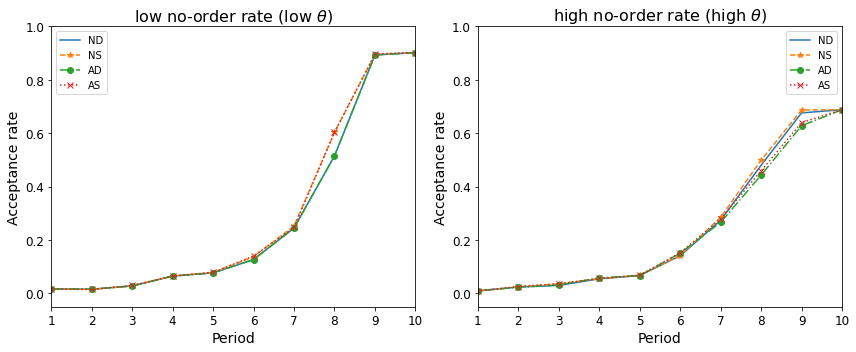

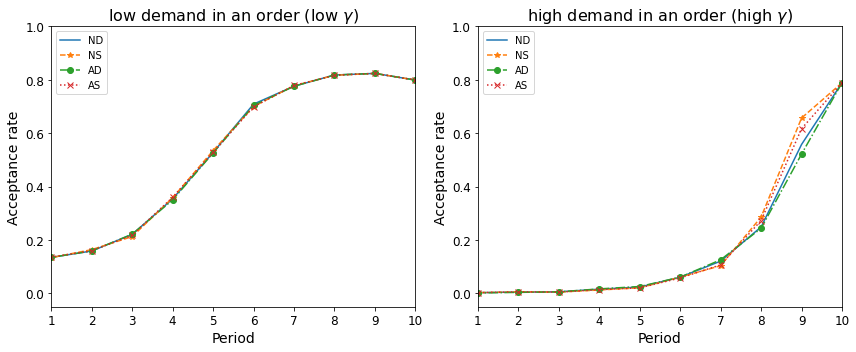

In [14]:
settings_list = [[["m5", "normal"], ["m15", "m20"]], [["b50", "b90"]], [["r1", "r3"]], [["d10", "d40"]]]
paths = ["m", "beta", "theta", "gamma"]
for t in range(len(settings_list)):
    s = settings_list[t]
    path = paths[t]
    print_decision(dfs_concat, s, result_folder + path)

## Appendix

In [12]:
# Find best alpha for AD and AS in each setting
target = "R_"
# pols = ["ND", "NS"]
pols = ["AS_alpha{}".format(a) for a in range(8, -2, -2)]
avg_targets = {p:[] for p in pols}
                    
for s in settings:
    for p in pols:
        not_include = "20"
        avg_target = round(float(get_item_by_keyword(dfs_concat[s], [target, p], not_include).mean()),1)
        avg_targets[p].append(avg_target)

df_datas = pd.DataFrame(avg_targets, index = [titles[s].split("(")[0] for s in settings])
df_datas

,AS_alpha8,AS_alpha6,AS_alpha4,AS_alpha2,AS_alpha0
normal,508739.0,508767.0,508690.0,508744.2,508730.8
high individual demand,688467.2,688467.2,688467.2,688467.2,688467.2
moderate individual demand,375032.9,374684.2,374720.9,374717.9,374721.4
low individual demand,311297.6,311922.2,311260.4,311250.9,311598.5
low order price,464473.0,464174.8,464430.8,463977.2,463623.2
high order price,574961.6,574645.0,575096.1,574971.9,574910.3
low no-order rate,518163.1,518155.2,518584.6,518222.4,518399.0
high no-order rate,538172.8,538076.9,538176.7,538176.0,538114.2
low demand in an order,496837.8,496822.9,496759.7,496665.6,496739.3
high demand in an order,503570.0,503385.0,503639.6,503318.2,503667.3


In [13]:
# Latex form
latex = df_datas.copy()
for c in latex.columns:
    latex[c] = latex[c].apply(lambda x: "& {}".format(x))
    if c == list(latex.columns)[-1]:
        latex[c] = latex[c].apply(lambda x: "{}\\\\".format(x))
    
latex

,AS_alpha8,AS_alpha6,AS_alpha4,AS_alpha2,AS_alpha0
normal,& 508739.0,& 508767.0,& 508690.0,& 508744.2,& 508730.8\\
high individual demand,& 688467.2,& 688467.2,& 688467.2,& 688467.2,& 688467.2\\
moderate individual demand,& 375032.9,& 374684.2,& 374720.9,& 374717.9,& 374721.4\\
low individual demand,& 311297.6,& 311922.2,& 311260.4,& 311250.9,& 311598.5\\
low order price,& 464473.0,& 464174.8,& 464430.8,& 463977.2,& 463623.2\\
high order price,& 574961.6,& 574645.0,& 575096.1,& 574971.9,& 574910.3\\
low no-order rate,& 518163.1,& 518155.2,& 518584.6,& 518222.4,& 518399.0\\
high no-order rate,& 538172.8,& 538076.9,& 538176.7,& 538176.0,& 538114.2\\
low demand in an order,& 496837.8,& 496822.9,& 496759.7,& 496665.6,& 496739.3\\
high demand in an order,& 503570.0,& 503385.0,& 503639.6,& 503318.2,& 503667.3\\


## Store avg revs and times

In [14]:
target = "R_"
rev_columns = list(get_item_by_keyword(dfs_concat["normal"], [target]).columns)
datas = dict(zip(rev_columns, [[] for i in rev_columns]))

for setting in settings:
    data = get_item_by_keyword(dfs_concat[setting], [target]).mean().to_dict()
    for p in datas:
        datas[p].append(data[p])

df_datas = pd.DataFrame(datas, index = settings)
df_datas.index.name = "Setting"
path = result_folder + "avg_revs.csv"
df_datas.to_csv(path)
df_datas

,R_ND,R_NS,R_AD_alpha20,R_AD_alpha18,R_AD_alpha16,R_AD_alpha14,R_AD_alpha12,R_AD_alpha10,R_AD_alpha8,R_AD_alpha6,...,R_AS_alpha18,R_AS_alpha16,R_AS_alpha14,R_AS_alpha12,R_AS_alpha10,R_AS_alpha8,R_AS_alpha6,R_AS_alpha4,R_AS_alpha2,R_AS_alpha0
Setting,,,,,,,,,,,,,,,,,,,,,
normal,507270.881,508724.628,507733.975,507719.981,507664.872,507434.078,507380.133,507343.549,507313.486,507277.165,...,508770.778,508756.709,508653.871,508809.105,508843.628,508738.983,508767.040,508690.028,508744.188,508730.829
m5,688469.364,688467.192,688479.420,688479.420,688479.420,688469.364,688469.364,688469.364,688469.364,688469.364,...,688479.420,688479.420,688479.420,688467.192,688467.192,688467.192,688467.238,688467.238,688467.192,688467.192
m15,370502.473,374683.183,370502.473,370502.473,370502.473,370502.473,370502.473,370502.473,370502.473,370502.473,...,374611.375,375038.998,374935.987,374614.561,374754.367,375032.882,374684.250,374720.920,374717.906,374721.402
m20,310612.369,311425.839,310612.369,310612.369,310612.369,310612.369,310612.369,310612.369,310612.369,310612.369,...,311375.461,311344.922,311208.779,311237.150,311389.305,311297.571,311922.232,311260.427,311250.893,311598.537
b50,460629.302,463764.260,460822.685,461271.705,461361.954,461324.172,461170.390,461148.717,460926.503,460806.588,...,464601.811,464953.270,464704.373,464549.989,464649.013,464473.020,464174.750,464430.794,463977.194,463623.241
b90,573368.922,574875.635,573465.105,573389.145,573349.181,573289.724,573289.724,573289.724,573320.710,573331.086,...,574890.509,574846.310,574600.549,574727.968,574591.269,574961.579,574644.993,575096.120,574971.862,574910.317
r1,515612.047,518297.564,516475.686,516445.516,516271.972,516245.520,516083.426,516050.505,516015.513,516003.182,...,518656.523,518826.192,518546.986,518309.619,518505.550,518163.058,518155.206,518584.618,518222.443,518399.040
r3,534984.179,538402.254,534890.564,534889.089,534994.321,534895.872,535005.261,535014.548,535062.118,535053.666,...,538088.019,538080.568,538058.666,538064.213,538103.130,538172.778,538076.917,538176.664,538175.990,538114.248
d10,495480.793,496508.618,496398.930,495945.530,495909.549,495892.431,495889.306,495784.235,495746.411,495601.411,...,497182.904,497219.092,497113.531,497009.668,497015.291,496837.816,496822.852,496759.692,496665.577,496739.269


In [15]:
# for s in settings:
target = "T_"
rev_columns = list(get_item_by_keyword(dfs_concat["normal"], [target]).columns)
datas = dict(zip(rev_columns, [[] for i in rev_columns]))

for setting in settings:
    data = get_item_by_keyword(dfs_concat[setting], [target]).sum().to_dict()
    for p in datas:
        datas[p].append(data[p])

df_datas = pd.DataFrame(datas, index = settings)
df_datas.index.name = "Setting"
path = result_folder + "sum_times.csv"
df_datas.to_csv(path)
df_datas

,T_ND,T_NS,T_AD_alpha20,T_AD_alpha18,T_AD_alpha16,T_AD_alpha14,T_AD_alpha12,T_AD_alpha10,T_AD_alpha8,T_AD_alpha6,...,T_AS_alpha18,T_AS_alpha16,T_AS_alpha14,T_AS_alpha12,T_AS_alpha10,T_AS_alpha8,T_AS_alpha6,T_AS_alpha4,T_AS_alpha2,T_AS_alpha0
Setting,,,,,,,,,,,,,,,,,,,,,
normal,1.0,382.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,...,387.0,386.0,385.0,385.0,382.0,382.0,382.0,383.0,382.0,382.0
m5,2.0,405.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,...,407.0,407.0,402.0,406.0,406.0,414.0,409.0,420.0,408.0,408.0
m15,1.0,312.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,...,308.0,312.0,312.0,312.0,311.0,314.0,309.0,312.0,312.0,312.0
m20,1.0,341.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,...,338.0,335.0,337.0,334.0,335.0,336.0,335.0,337.0,334.0,335.0
b50,2.0,465.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,...,534.0,520.0,500.0,490.0,481.0,474.0,471.0,475.0,466.0,464.0
b90,2.0,384.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,...,388.0,386.0,383.0,385.0,384.0,388.0,386.0,388.0,387.0,384.0
r1,1.0,394.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,...,400.0,399.0,396.0,396.0,397.0,393.0,395.0,395.0,397.0,397.0
r3,1.0,408.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,...,405.0,402.0,404.0,405.0,401.0,400.0,404.0,402.0,401.0,403.0
d10,2.0,414.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,421.0,420.0,420.0,415.0,421.0,418.0,420.0,415.0,415.0,417.0
